# **Twitter Stock Sentiment**

# **1.0 INTRODUCTION**
In addition to our **reinforcement learning** project, it would be interested to conduct **sentiment analysis** on tweets from twitter regarding companies from the Dow Jones Industrial Index. <br><br>
This portion of the project will focus on building **classification models** to classify tweets into either **positive** or **negative** sentiments.

## **1.1 Import Dependencies**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import nltk
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
from scipy.sparse.csr import csr_matrix
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from gensim.models import Word2Vec

In [2]:
DOW_30_TICKERS = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC", 
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW"
]

## **1.2 EDA**

Our data has already been cleaned prior to importing.

In [3]:
data = pd.read_csv('data/stock_data.csv', encoding= 'unicode_escape')
data.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,AAP MOVIE. 55% return for the FEA/GEED indica...,1
2,I'd be afraid to sho AMZN - they are looking ...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


The data simply consists of 2 columns: <br>
- **text**, <br>
- **sentiment**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


Thankfully, no missing values. <br> <br>
With classification modelling, it is important to view if there exist an **imbalance** of target values.

In [5]:
data['Sentiment'].value_counts(normalize=True)

 1    0.636332
-1    0.363668
Name: Sentiment, dtype: float64

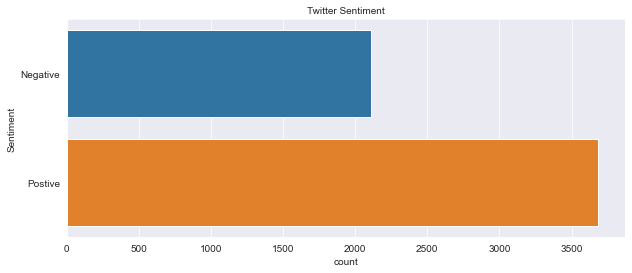

In [6]:
fig, ax = plt.subplots(figsize = (10, 4))
ax = sns.countplot(data = data, y = 'Sentiment')
ax.set_title('Twitter Sentiment', fontsize = 10)
ax.set_yticklabels(['Negative', 'Postive']);

Here we can see an imbalanced dataset, with 63% positive sentiments and 37% negative sentiments. We'll be mindful of this when we do our modelling. <br> <br>
We can conduct some EDA to visualise other features.

**Character length vs sentiment**

In [7]:
data['character_length'] = data['Text'].apply(lambda x: len(x))

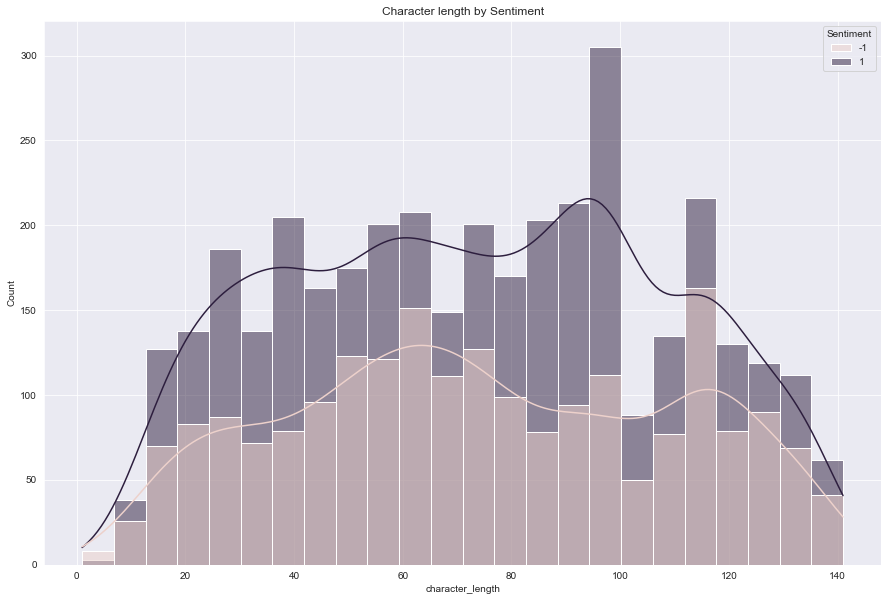

In [8]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.histplot(data = data, x = 'character_length', hue = 'Sentiment', kde = True)
ax.set_title('Character length by Sentiment');

**Word count vs sentiment**

In [9]:
data['word_count'] = data['Text'].apply(lambda x: len(x.split(' ')))

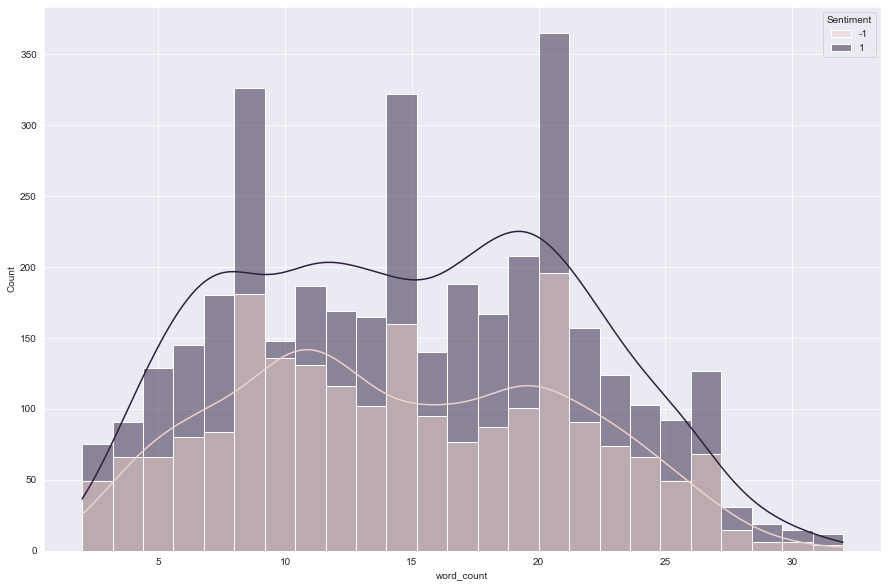

In [10]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.histplot(data = data, x = 'word_count', hue = 'Sentiment', kde = True)

# **2.0 DATA PREPARATION**

## **2.1 Train test split**
When doing our train test split, we need to remember that we have an imbalanced dataset. <br><br>
When dealing with NLP, **SMOTE** is not an option. The only option is to **stratify** our test set so that distribution matches that of our original dataset.

In [11]:
X = data['Text']
y = data['Sentiment']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [13]:
y_train.value_counts(normalize=True)

 1    0.636426
-1    0.363574
Name: Sentiment, dtype: float64

In [14]:
y_test.value_counts(normalize=True)

 1    0.63605
-1    0.36395
Name: Sentiment, dtype: float64

## **2.2 PREPROCESSING**
When performing NLP, there are various prerocessing steps we must take before feeding the text into our classification model. Our steps will be:
- **Lowercasing** the corpus
- Removing **punctuation** om the corpus
- **Tokenizing** our corpus
- Removing **stop words** from our tokens
- **Lemmatizing** each token

We first of all need to establish our **stop words**. We'll be utlising NLTKs library.

In [15]:
stopwords_list = nltk.corpus.stopwords.words('english')

We will also include all of the NYSE tickers.

In [35]:
NYSE = pd.read_csv('data/nyse-listed.csv')['ACT Symbol']
NYSE_TICKERS = NYSE.apply(lambda x: x.lower())

NASDAQ = pd.read_csv('data/nasdaq_constituents.csv')['Symbol']
NASDAQ_TICKERS = NASDAQ.apply(lambda x: x.lower())

DOW_30_TICKERS = [word.lower() for word in DOW_30_TICKERS]

complete_stopwords_list = list(stopwords_list) + list(NYSE_TICKERS) + DOW_30_TICKERS + list(NASDAQ_TICKERS) + ['stock', 'market', 'day', 'today', 'gmc', 'google', 'apple']

In [595]:
with open('NLP_models/complete_stopwords_list.pickle', 'wb') as handle:
    pickle.dump(complete_stopwords_list, handle, protocol = pickle.HIGHEST_PROTOCOL)

We'll now make a simple function to summarise our preprocessing function.

In [371]:
def text_preprocessing(text):
    # lowercase
    text = text.lower()
    #remove ponctuation
    cleaned_text = re.sub("([^A-Za-z0-9|\s|[:punct:]]*)", '', text)
    # tokenize
    text_list = cleaned_text.split()
    # remove stopwords
    tokens = [word for word in text_list if word not in complete_stopwords_list]
    # lemmatize
    lemmatize = WordNetLemmatizer()
    lemmatized_list = [lemmatize.lemmatize(word) for word in tokens if len(lemmatize.lemmatize(word)) > 2]
    # rejoin our tokens into sentences
    words = ' '.join([word for word in lemmatized_list])
    return words

In [372]:
X_train_preprocessed = X_train.apply(lambda x: text_preprocessing(x))
X_test_preprocessed = X_test.apply(lambda x: text_preprocessing(x))

In [374]:
X_train_preprocessed

3773                        falling explain money worried
4540                                        owe stop 1845
3137    earnings flushed conference flushed annual mee...
1058                                            dont walk
1704                                     gap backfill fie
                              ...                        
5754           market crash plunge 1700 point early trade
5555    government begin fiscal year severe strain big...
2429                                      pphm going like
4468                grabbed otto 8250 put could breakdown
1962                                        dump progress
Name: Text, Length: 4343, dtype: object

## **2.3 Additional EDA**
Now that our training and testing data have been preprocessed, we can further inspect our corpus by using a **count vectorizer** on the processed data. 

In [375]:
cv = CountVectorizer(stop_words=complete_stopwords_list)

In [594]:
with open('NLP_models/count_vectorizer.pickle', 'wb') as handle:
    pickle.dump(cv, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [377]:
X_train_count_vectorized = cv.fit_transform(X_train_preprocessed)

The **count_list** is the sum of each column from our sparse matrix where each column represents a token/word from our corpus.
<br><br>
The **word_list** shows us each token/word in our corpus and its corresponding index value within our sparse matrix.


In [378]:
count_list = np.array(X_train_count_vectorized.sum(axis = 0))
word_list = cv.vocabulary_

In [379]:
count_list

array([[1, 1, 1, ..., 4, 1, 3]], dtype=int64)

In [380]:
word_list

{'falling': 3320,
 'explain': 3273,
 'money': 4704,
 'worried': 7037,
 'owe': 5072,
 'stop': 6238,
 '1845': 404,
 'earnings': 3022,
 'flushed': 3454,
 'conference': 2471,
 'annual': 1695,
 'meeting': 4605,
 'buy': 2168,
 'imho': 4007,
 'dont': 2923,
 'walk': 6882,
 'gap': 3584,
 'backfill': 1865,
 'fie': 3383,
 'anad': 1671,
 'fib': 3378,
 'level': 4397,
 'watch': 6900,
 'list': 4430,
 'close': 2376,
 'line': 4423,
 'volume': 6849,
 'full': 3546,
 'average': 1836,
 'yhoo': 7092,
 'cramer': 2595,
 'kiss': 4297,
 'death': 2712,
 'thanks': 6465,
 'jds': 4218,
 'nudge': 4891,
 'kifmonster': 4288,
 '30year': 720,
 'treasury': 6629,
 'yield': 7094,
 'settled': 5905,
 '1392': 234,
 'highest': 3858,
 'since': 5996,
 'march': 4550,
 'red': 5565,
 'bar': 1890,
 'size': 6010,
 'ruin': 5759,
 'target': 6411,
 'point': 5268,
 'made': 4510,
 'higher': 3856,
 'wait': 6875,
 'first': 3420,
 'like': 4416,
 'entry': 3139,
 '2264': 552,
 '2155': 526,
 'zcs': 7119,
 'almost': 1636,
 'hit': 3880,
 'lossgla

We'll now be combining the 2 together to get the **frequency** for each of our words.

In [381]:
frequency = [(word, count_list[0, i]) for word, i in word_list.items()]
frequency_df = pd.DataFrame(frequency, columns=['word', 'count'])

**Top 20** words

In [382]:
top_20 = frequency_df.sort_values(by = 'count', ascending=False)[:20]
top_20

,word,count
26,volume,220
55,like,210
5,stop,199
176,long,191
22,watch,155
75,high,149
12,buy,149
433,look,144
310,still,139
52,higher,137


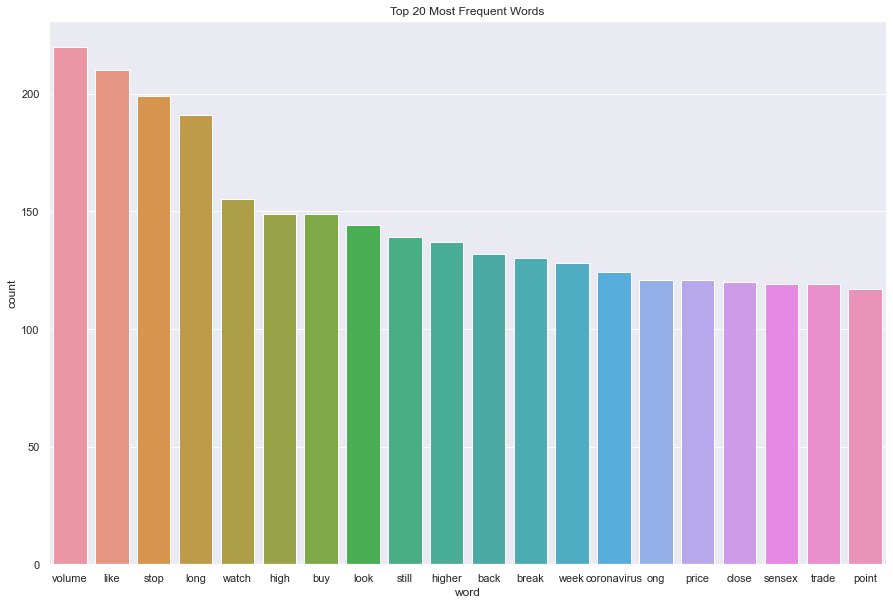

In [383]:
fig, ax = plt.subplots(figsize = (15, 10))
ax = sns.barplot(data = top_20, x = 'word', y = 'count')
ax.set_title('Top 20 Most Frequent Words');

### **Word Cloud**
We can also create a word cloud to help visualise the data. We'll make 2 words clouds, one for positive sentiments and the other for negative sentiments.

**Positive Sentiment Word Cloud**

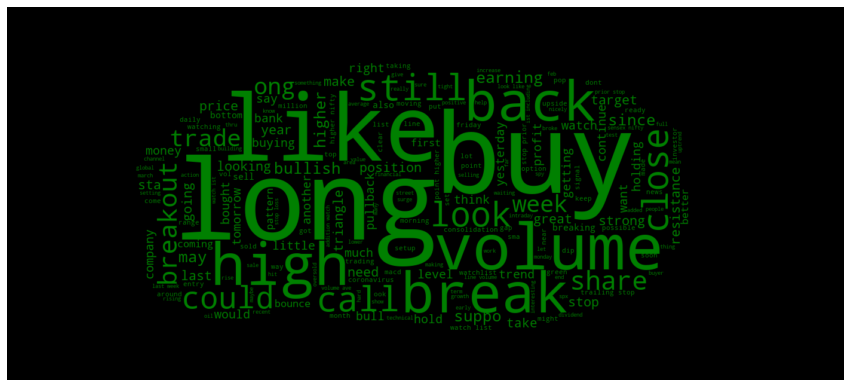

In [597]:
from PIL import Image
# data
positive_wc_data = data[data['Sentiment'] == 1]['Text'].map(text_preprocessing)
positive_wc_data = positive_wc_data.str.cat()

# Appearance
mask = np.array(Image.open('word_cloud/cloud.png'))

positive_wordcloud = WordCloud(background_color = None,
                                stopwords = complete_stopwords_list,
                                mask = mask,
                                color_func=lambda *args, **kwargs: (0,128,0))
                                
positive_wordcloud.generate(positive_wc_data)

# Plotting
fig, ax = plt.subplots(figsize = (15,10))
plt.imshow(positive_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Negative Sentiment Word Cloud**

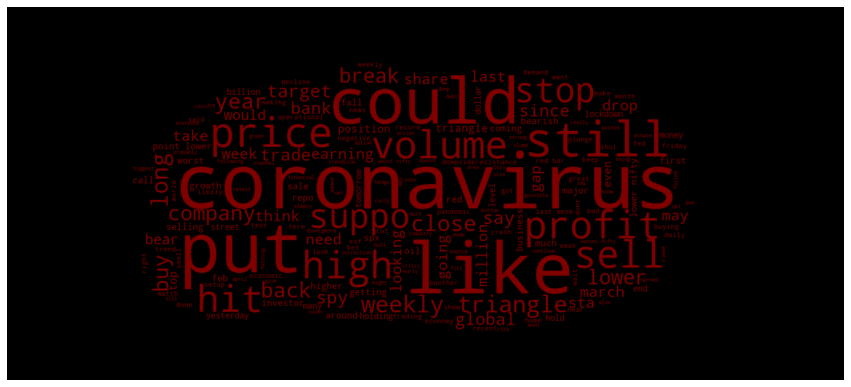

In [598]:

# data
negative_wc_data = data[data['Sentiment'] == -1]['Text'].map(text_preprocessing)
negative_wc_data = negative_wc_data.str.cat()

negative_wordcloud = WordCloud(background_color = None,
                                stopwords = complete_stopwords_list,
                                mask = mask,
                                color_func=lambda *args, **kwargs: (128,0,0))
                                
negative_wordcloud.generate(negative_wc_data)

# Plotting
fig, ax = plt.subplots(figsize = (15,10))
plt.imshow(negative_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [600]:
plt.savefig(fig, 'test.png', transparent = True)

TypeError: savefig() takes 2 positional arguments but 3 positional arguments (and 1 keyword-only argument) were given

<Figure size 1080x576 with 0 Axes>

### **Word Similarity**
We can also view wthe similarity between words. We can do this buy utilising the **word2vec** model.
<br><br>
Our words of interest are **buy** and **sell**.

In [386]:
# tokenize our words
word2vec_X_train = X_train_preprocessed.apply(lambda x: x.split(' '))

# initialising our model
word2vec_model = Word2Vec(word2vec_X_train, window=5, min_count=2, workers = 4)

# training our w2v model
word2vec_model.train(word2vec_X_train, 
                     total_examples = word2vec_model.corpus_count, 
                     epochs = word2vec_model.epochs)

word2vec_model.save('NLP_models/w2v_model.h5')

In [387]:
word2vec_model.wv.most_similar(['buy'])

[('company', 0.9999390840530396),
 ('money', 0.9999351501464844),
 ('may', 0.9999327063560486),
 ('share', 0.9999325275421143),
 ('target', 0.9999293684959412),
 ('even', 0.9999272227287292),
 ('right', 0.9999239444732666),
 ('would', 0.9999202489852905),
 ('still', 0.9999202489852905),
 ('since', 0.9999192953109741)]

In [388]:
word2vec_model.wv.most_similar(['sell'])

[('position', 0.9998749494552612),
 ('long', 0.9998228549957275),
 ('bull', 0.999822735786438),
 ('take', 0.999819815158844),
 ('bullish', 0.9998055696487427),
 ('lot', 0.9998009204864502),
 ('dont', 0.9997940063476562),
 ('put', 0.9997819662094116),
 ('check', 0.9997774362564087),
 ('make', 0.9997761845588684)]

# **3.0 Traditional Modelling**
For our modelling, we'll first be using a suite of traditional classification models and then we'll move onto using neural networks. <br><br>
Our **baseline** model would be a scenario in which the algorithm guesses the majority sentiment each time i.e. **63% accuracy**.

## **3.1 Untuned Traditional Classification Models**
Our classification models will consist of 4 types:
- ***Logistic Regression***
- ***Naive Bayes***
- ***Random Forest***
- ***Gradient Boost***

In [389]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix

We'll get the list of our models.

In [390]:
models = [
         {'name': 'Logistic_regresion',
         'classifier': LogisticRegression(fit_intercept=False, C=1e12, solver = 'liblinear', class_weight='balanced'),
         'val_accuracy_score': None
         },
         {'name': 'Naive_Bayes',
         'classifier': MultinomialNB(),
         'val_accuracy_score': None
         },
         {'name': 'Random_Forest',
         'classifier': RandomForestClassifier(n_jobs = 2, max_depth = 5, class_weight='balanced'),
         'val_accuracy_score': None
         },
         {'name': 'Gradient_boost',
         'classifier': GradientBoostingClassifier(),
         'val_accuracy_score': None}
         ]

We'll create a simple function to get our classification metrics and also plot a confusion matrix.

In [393]:
def model_evaluation(X_train,
                     y_train,
                     model):
        
    # Cross validation
    cross_val_model = cross_validate(
                        estimator = model['classifier'], 
                        X = X_train, 
                        y = y_train, 
                        scoring = ["accuracy", 'f1', 'recall', 'precision'],
                        return_train_score=True, 
                        cv=5)
                        

    # getting our scores
    model['val_accuracy_score'] = np.mean(cross_val_model['test_accuracy'])
    model['val_recall_score'] = np.mean(cross_val_model['test_recall'])
    model['val_f1_score'] = np.mean(cross_val_model['test_f1'])
    model['val_precision_score'] = np.mean(cross_val_model['test_precision'])

    # creating confusion matrix
    y_pred = cross_val_predict(
                                model['classifier'],
                                X = X_train,
                                y = y_train,
                                cv = 5
    )

    conf_mat = confusion_matrix(y_train, y_pred)

    plt.figure(figsize =(8, 6))
    sns.heatmap(conf_mat, annot = True, yticklabels = ['negative', 'positive'], xticklabels = ['negative', 'positive'], cmap = 'Blues', fmt = 'g')
    plt.xlabel('Predicted');
    plt.ylabel('Actual');
    plt.title(f"{model['name']} Confusion Matrix");
    plt.show()

    print(f"Model: {model['name']}")
    print(f"val accuracy: {round(model['val_accuracy_score'], 3)}")
    print(f"val recall: {round(model['val_recall_score'], 3)}")
    print(f"val f1: {round(model['val_f1_score'], 3)}")
    print(f"val precision: {round(model['val_precision_score'], 3)}")

    #Place everything into a dictionary to return
    summary_dict = {'name': model['name'],
                    'val_accuracy_score': model['val_accuracy_score'],
                    'val_recall_score': cross_val_model['test_recall'],
                    'val_f1_score': cross_val_model['test_f1'],
                    'val_precision_score': cross_val_model['test_precision'],
                    'confusion_matrix': conf_mat
                    }

    return summary_dict

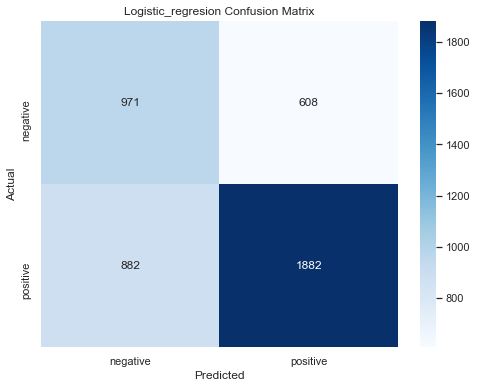

Model: Logistic_regresion
val accuracy: 0.657
val recall: 0.681
val f1: 0.716
val precision: 0.756


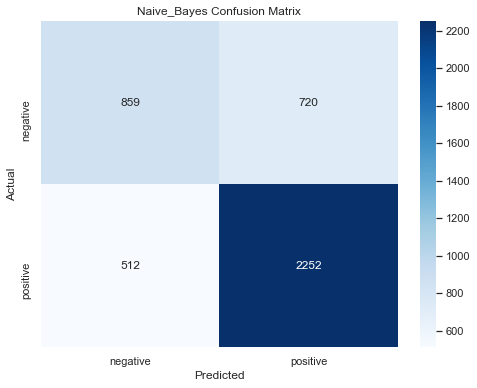

Model: Naive_Bayes
val accuracy: 0.716
val recall: 0.815
val f1: 0.785
val precision: 0.758


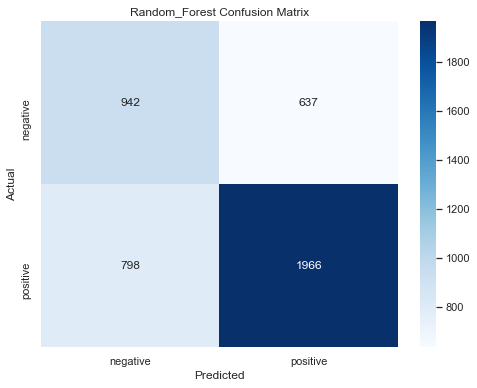

Model: Random_Forest
val accuracy: 0.671
val recall: 0.702
val f1: 0.724
val precision: 0.767


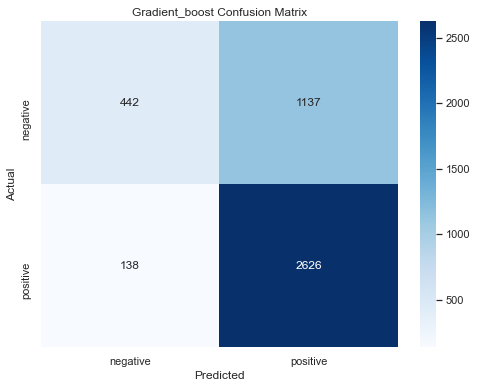

Model: Gradient_boost
val accuracy: 0.707
val recall: 0.952
val f1: 0.805
val precision: 0.698


In [394]:
summary_list = []

for model in models: 
    summary_list.append(model_evaluation(X_train_count_vectorized, y_train, model))

In [395]:
classifiers = [classifier['name'] for classifier in summary_list]
val_accuracy = [np.mean(classifier['val_accuracy_score']) for classifier in summary_list]
val_recall = [np.mean(classifier['val_recall_score']) for classifier in summary_list]
val_precision = [np.mean(classifier['val_precision_score']) for classifier in summary_list]
val_f1 = [np.mean(classifier['val_f1_score']) for classifier in summary_list]

val_summary_DataFrame = pd.DataFrame({'classifiers': classifiers, 
                                'val_accuracy': val_accuracy, 
                                'val_recall': val_recall,
                                'val_precision': val_precision,
                                'val_recall': val_recall,
                                'val_f1': val_f1})

val_summary_DataFrame = val_summary_DataFrame.sort_values(by = 'val_accuracy', ascending = False)
val_summary_DataFrame

,classifiers,val_accuracy,val_recall,val_precision,val_f1
1,Naive_Bayes,0.716318,0.814759,0.757782,0.785142
3,Gradient_boost,0.706879,0.951523,0.698015,0.805190
2,Random_Forest,0.670732,0.702180,0.766767,0.724102
0,Logistic_regresion,0.656912,0.680882,0.755738,0.716198


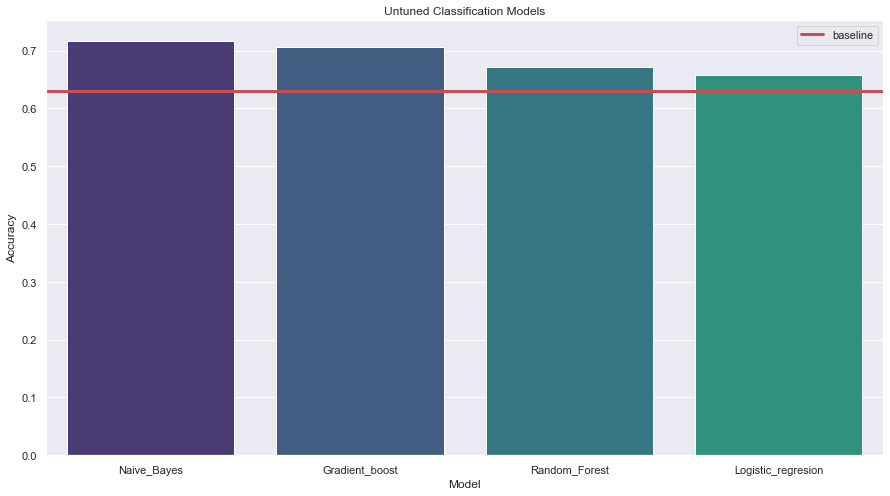

In [396]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(data = val_summary_DataFrame, x = 'classifiers', y = 'val_accuracy', palette=sns.color_palette("viridis"))
ax.axhline(0.63, linewidth = 3, color = 'r', label = 'baseline')
ax.set_title('Untuned Classification Models')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show();

Great. Even with our traditional models being untuned, they were all able to outperform the baseline model.

## **3.2 Tuned Traditional Classification Models**
We'll incorporate **optuna** to help us tune our models.

In [194]:
import optuna

In [ ]:
# sampler determines which hyperparameters to choose
sampler = optuna.samplers.TPESampler(seed = 42)

# pruner terminates a model early if it doesn't yield good results
pruner = optuna.pruners.HyperbandPruner()

In [196]:
tuned_models_summary = []

**Defining our objective function** <br><br>
We'll be focusing on **maximising accuracy**. We'll only need to make 3 objective functions as the naive bayes classifier requires no tuning.

**Logistic Regression Tuning**

In [220]:
def lr_objective_function(trial):
  
  logreg_c = trial.suggest_float("C", 1e-10, 1e10, log=True)
  max_iter = trial.suggest_int('max_iter', 100, 500)

  clf = LogisticRegression(fit_intercept = False,
                           class_weight= 'balanced',
                           max_iter = max_iter,
                           C = logreg_c
                           )

  validation_accuracy = np.mean(cross_val_score(clf, X_train_count_vectorized, y_train, cv = 5))
  
  return validation_accuracy

study_lr = optuna.create_study(direction = 'maximize')
study_lr.optimize(lr_objective_function, n_trials = 100)
lr_best_params = study_lr.best_params

tuned_lr_model = LogisticRegression(fit_intercept = False,
                                    class_weight = 'balanced',
                                    max_iter = lr_best_params['max_iter'],
                                    C = lr_best_params['C']
                                    )

[I 2022-04-03 00:48:53,235] A new study created in memory with name: no-name-a35e03e0-eb3d-4035-8ddc-2758a1bb0d51
[I 2022-04-03 00:48:54,440] Trial 0 finished with value: 0.6912169292528623 and parameters: {'C': 423.39048477066865, 'max_iter': 258}. Best is trial 0 with value: 0.6912169292528623.
[I 2022-04-03 00:48:54,999] Trial 1 finished with value: 0.722301442942521 and parameters: {'C': 2.1989796882604513, 'max_iter': 396}. Best is trial 1 with value: 0.722301442942521.
[I 2022-04-03 00:48:55,404] Trial 2 finished with value: 0.7216107290015008 and parameters: {'C': 3.1634812761869626, 'max_iter': 124}. Best is trial 1 with value: 0.722301442942521.
[I 2022-04-03 00:48:55,523] Trial 3 finished with value: 0.6852293276343908 and parameters: {'C': 6.018439210971526e-09, 'max_iter': 180}. Best is trial 1 with value: 0.722301442942521.
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=

**Random Forest Tuning**

In [221]:
def random_forest_objective_function(trial):
  
  n_estimators = trial.suggest_int("n_estimators", 10, 1000)
  max_depth = trial.suggest_int("max_depth", 2, 32, log = True)
  criterion = trial.suggest_categorical("criterion", ['gini', 'entropy'])

  clf = RandomForestClassifier(class_weight='balanced',
                               criterion = criterion,
                               n_estimators = n_estimators,
                               max_depth = max_depth
  )

  validation_accuracy = np.mean(cross_val_score(clf, X_train_count_vectorized, y_train, cv = 5))

  return validation_accuracy

study_rf = optuna.create_study(direction = 'maximize')
study_rf.optimize(random_forest_objective_function, n_trials = 100)
rf_best_params = study_rf.best_params

tuned_rf_model = RandomForestClassifier(class_weight='balanced',
                                        criterion = rf_best_params['criterion'],
                                        n_estimators = rf_best_params['n_estimators'],
                                        max_depth = rf_best_params['max_depth']
                                        )

[I 2022-04-03 00:49:55,317] A new study created in memory with name: no-name-5455bddc-ba57-4fe6-8e1b-60eeb24cb1e6
[I 2022-04-03 00:50:04,413] Trial 0 finished with value: 0.6965111654372577 and parameters: {'n_estimators': 578, 'max_depth': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.6965111654372577.
[I 2022-04-03 00:50:36,543] Trial 1 finished with value: 0.7154019928621806 and parameters: {'n_estimators': 812, 'max_depth': 17, 'criterion': 'gini'}. Best is trial 1 with value: 0.7154019928621806.
[I 2022-04-03 00:51:04,573] Trial 2 finished with value: 0.7151726387128592 and parameters: {'n_estimators': 591, 'max_depth': 21, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7154019928621806.
[I 2022-04-03 00:51:10,555] Trial 3 finished with value: 0.7043513652537744 and parameters: {'n_estimators': 219, 'max_depth': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7154019928621806.
[I 2022-04-03 00:51:18,845] Trial 4 finished with value: 0.679257104675642

**Gradient Boosting Tuning**

In [222]:
def gradient_boosting_objective_function(trial):
  
  n_estimators = trial.suggest_int("n_estimators", 10, 1000)
  max_depth = trial.suggest_int("max_depth", 2, 32, log = True)
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1)

  clf = GradientBoostingClassifier(learning_rate = learning_rate,
                                    n_estimators = n_estimators,
                                    max_depth = max_depth
  )

  validation_accuracy = np.mean(cross_val_score(clf, X_train_count_vectorized, y_train, cv = 5))

  return validation_accuracy

study_gb = optuna.create_study(direction = 'maximize')
study_gb.optimize(gradient_boosting_objective_function, n_trials = 100)
gb_best_params = study_gb.best_params

tuned_gb_model = GradientBoostingClassifier(learning_rate = gb_best_params['learning_rate'],
                                            n_estimators = gb_best_params['n_estimators'],
                                            max_depth = gb_best_params['max_depth']
                                            )

[I 2022-04-03 01:30:25,104] A new study created in memory with name: no-name-78a23931-b569-4f81-b10c-ff2a79e9598b
[I 2022-04-03 01:33:54,099] Trial 0 finished with value: 0.6364264767490575 and parameters: {'n_estimators': 561, 'max_depth': 20, 'learning_rate': 1.051282333900783e-05}. Best is trial 0 with value: 0.6364264767490575.
[I 2022-04-03 01:35:11,092] Trial 1 finished with value: 0.6364264767490575 and parameters: {'n_estimators': 483, 'max_depth': 4, 'learning_rate': 3.632123269814264e-05}. Best is trial 0 with value: 0.6364264767490575.
[I 2022-04-03 01:37:28,257] Trial 2 finished with value: 0.7241505941995937 and parameters: {'n_estimators': 409, 'max_depth': 28, 'learning_rate': 0.04992338275994205}. Best is trial 2 with value: 0.7241505941995937.
[I 2022-04-03 01:41:57,809] Trial 3 finished with value: 0.687082721280353 and parameters: {'n_estimators': 609, 'max_depth': 25, 'learning_rate': 0.0005631733762163737}. Best is trial 2 with value: 0.7241505941995937.
[I 2022-04

**Putting it all together**

In [223]:
tuned_models = [
                {'name': 'Tuned Logistic_regresion',
                'classifier': tuned_lr_model
                },
                {'name': 'Tuned Random_Forest',
                'classifier': tuned_rf_model
                },
                {'name': 'Tuned Gradient_boost',
                'classifier': tuned_gb_model
                }
                ]

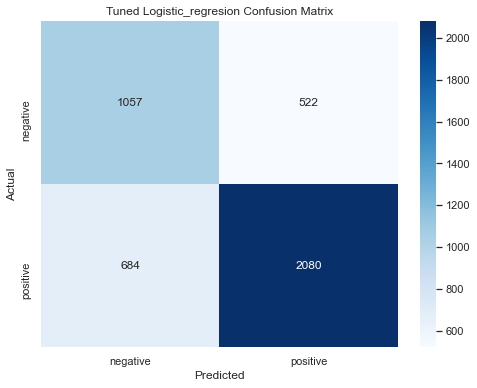

Model: Tuned Logistic_regresion
val accuracy: 0.722
val recall: 0.753
val f1: 0.775
val precision: 0.799


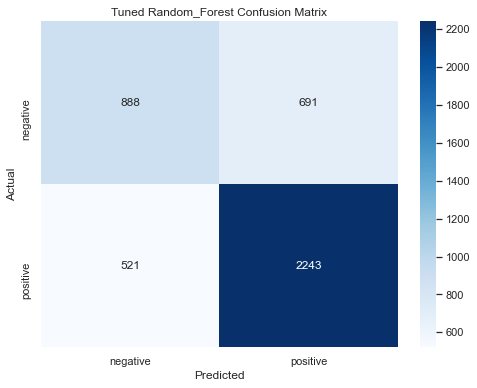

Model: Tuned Random_Forest
val accuracy: 0.724
val recall: 0.813
val f1: 0.789
val precision: 0.768


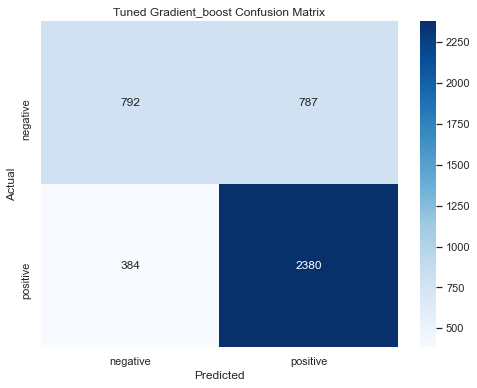

Model: Tuned Gradient_boost
val accuracy: 0.733
val recall: 0.869
val f1: 0.806
val precision: 0.752


In [534]:
for model in tuned_models: 
    summary_list.append(model_evaluation(X_train_count_vectorized, y_train, model))

In [535]:
classifiers = [classifier['name'] for classifier in summary_list]
val_accuracy = [np.mean(classifier['val_accuracy_score']) for classifier in summary_list]
val_recall = [np.mean(classifier['val_recall_score']) for classifier in summary_list]
val_precision = [np.mean(classifier['val_precision_score']) for classifier in summary_list]
val_f1 = [np.mean(classifier['val_f1_score']) for classifier in summary_list]

val_summary_DataFrame = pd.DataFrame({'classifiers': classifiers, 
                                    'val_accuracy': val_accuracy, 
                                    'val_recall': val_recall,
                                    'val_precision': val_precision,
                                    'val_recall': val_recall,
                                    'val_f1': val_f1})

In [548]:
val_summary_DataFrame = val_summary_DataFrame.sort_values(by = 'val_accuracy', ascending = False)
val_summary_DataFrame

,classifiers,val_accuracy,val_recall,val_precision,val_f1
6,Tuned Gradient_boost,0.733358,0.868672,0.751636,0.805746
5,Tuned Random_Forest,0.724382,0.813325,0.768382,0.789302
4,Tuned Logistic_regresion,0.722302,0.752523,0.799262,0.775105
1,Naive_Bayes,0.716318,0.814759,0.757782,0.785142
3,Gradient_boost,0.706879,0.951523,0.698015,0.805190
2,Random_Forest,0.670732,0.702180,0.766767,0.724102
0,Logistic_regresion,0.656912,0.680882,0.755738,0.716198


In [557]:
for column in val_summary_DataFrame.columns[1:]:
    val_summary_DataFrame[column] = val_summary_DataFrame[column].apply(lambda x: round(x, 3))

In [558]:
val_summary_DataFrame.to_csv('data/NLP_summary_df.csv', index = False)

In [559]:
val_summary_DataFrame = pd.read_csv('data/NLP_summary_df.csv')

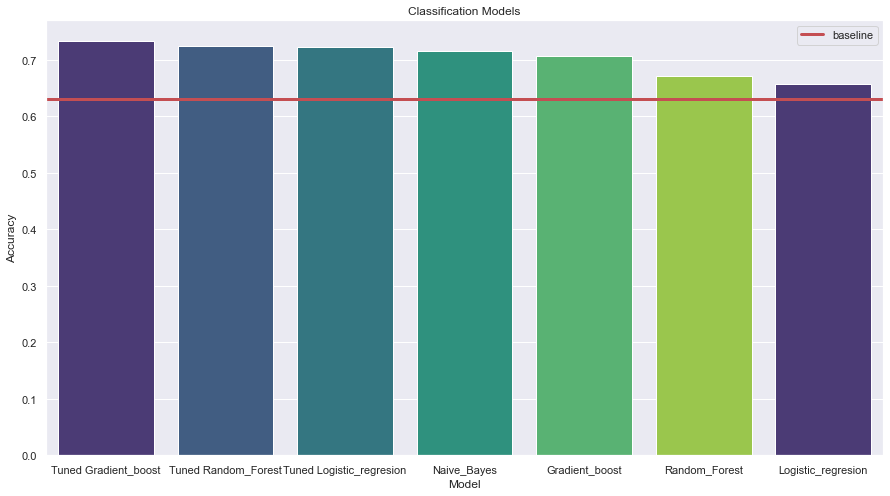

In [536]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15,8)})
ax = sns.barplot(data = val_summary_DataFrame, x = 'classifiers', y = 'val_accuracy', palette=sns.color_palette("viridis"))
ax.axhline(0.63, linewidth = 3, color = 'r', label = 'baseline')
ax.set_title('Classification Models')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
plt.legend()
plt.show();

In [555]:
import plotly.express as px

fig = px.bar(
    val_summary_DataFrame,
    x = 'classifiers',
    y = 'val_accuracy',
    hover_data = ['val_recall', 'val_precision', 'val_f1'],
    color = 'val_accuracy',
    color_continuous_scale = px.colors.sequential.matter,
    title = 'NLP model summary',
    height = 720,
    width = 1280
)

fig.add_hline(
    y = 0.63,
    line_dash = 'dot',
    line_color = 'black'
)

fig.update_layout(
    yaxis = dict(
        title_text="Val Accuracy (%)"
    ),
    xaxis = dict(
        title_text = 'Classifiers'
    )
)

fig.show()

AttributeError: 'Figure' object has no attribute 'add_hline'

In [ ]:
fig.write_html('webapp/graphs/NLP_summary.html')

In [229]:
import pickle
with open('NLP_models/tuned_gradient_boosting_model.pickle', 'wb') as handle:
    pickle.dump(tuned_gb_model, handle, protocol = pickle.HIGHEST_PROTOCOL)

## **Using our best model on test data**

In [553]:
X_test_count_vectorized = cv.transform(X_test_preprocessed)
tuned_gb_model.fit(X_train_count_vectorized, y_train)
test_preds = tuned_gb_model.predict(X_test_count_vectorized)
test_accuracy = accuracy_score(y_test, test_preds)

**Test accuracy**

In [552]:
print(round(test_accuracy, 3))

0.752


<Figure size 1080x720 with 0 Axes>

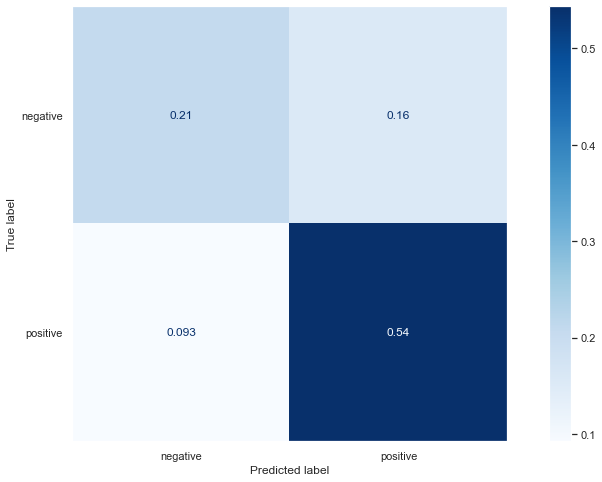

In [588]:
plt.figure(figsize = (15,10));

plot_confusion_matrix(
    tuned_gb_model, 
    X_test_count_vectorized, 
    y_test, 
    normalize = 'all',
    cmap = 'Blues',
    display_labels = ['negative', 'positive']
    );

plt.grid(False);

In [589]:
from joblib import dump, load

In [591]:
dump(tuned_gb_model, './NLP_models/NLP_model.joblib')

['./NLP_models/NLP_model.joblib']

In [4]:
round(0, 3)

0